In [1]:
from imagegrains import data_loader, grainsizing, plotting, gsd_uncertainty
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

>> Initializing ImageGrains with Cellpose legacy release (v2).


## Download pre-trained models and demo data  
If you have not donwloaded the pre-trained models and demo data yet from github, please see notebook **1_image_segmentation**. If you want to run on your own data, you can set the path manually in the next cell.

In [2]:
data_path = Path('F:/demo/debug')

This notebook will try to use segementation results from **1_image_segmentation** and the measured grain sizes from **2_grain_sizes**.

In [3]:
download_path = Path.home().joinpath('imagegrains')
data_path = download_path.joinpath('demo_data','FH').as_posix()

#ascertain Cellpose version
try:
    from imagegrains import __cp_version__
except:
    __cp_version__ = 2

#set model_id to default model based on Cellpose version
if __cp_version__ < 4:
    model_id = 'IG2_full_set'
elif __cp_version__ >= 4:
    model_id = 'IG2_full_set_cp_SAM'

## Load the scaled results

In [4]:
#find results in folder for 'fh_pred'
fh_pred_gsds = data_loader.load_grain_set(data_path,gsd_str='pred_grains_re_scaled')
#find results in folder for label masks
gt_mask_gsds = data_loader.load_grain_set(data_path,gsd_str='mask_grains_re_scaled')

## Calculate the grain size disdtributions (GSD)

In [5]:
#specify column name for axis
column_name='ell: b-axis (mm)'
#load results and get gsd for each image for a specific axis column
fh_gsd_l,fh_id_l = grainsizing.gsd_for_set(fh_pred_gsds,column=column_name)
#do the same for label masks
gt_gsd_l,gt_id_l = grainsizing.gsd_for_set(gt_mask_gsds,column=column_name)

### Plot the GSDs

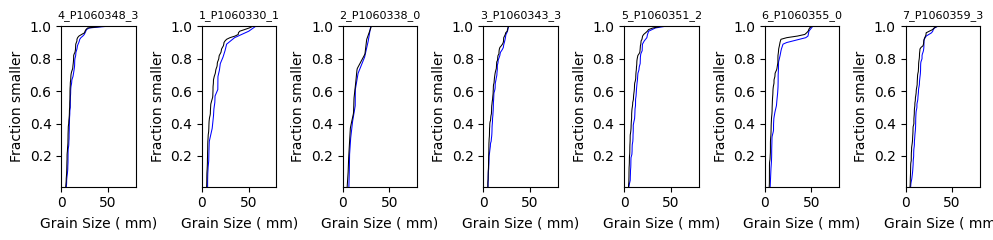

In [6]:
plt.figure(figsize=(10,2.5))
for i in range(len(fh_gsd_l)):
    plt.subplot(1,len(fh_gsd_l),i+1)
    plotting.plot_gsd(fh_gsd_l[i],color='b',length_max=80,orientation='vertical',label_axes=True,units= 'mm')
    plotting.plot_gsd(gt_gsd_l[i],color='k',length_max=80,orientation='vertical',label_axes=True,units= 'mm',title=fh_id_l[i].split(f'_{model_id}_pred')[0])

## Calculate percentile uncertainties

In [7]:
#number of iterations for randomization
num_it  = 1000

In [8]:
# Percentile uncertainty with bootstrapping (counting statistics only)
res_dict_bs = gsd_uncertainty.dataset_uncertainty(gsds=fh_pred_gsds,num_it=num_it,mute=True,column_name=column_name,return_results=True,sep=',',gsd_id = fh_id_l,tar_dir= data_path)
# Percentile uncertainty with Monte Carlo (counting statistics & scale, length uncertainty)
res_dict_MC = gsd_uncertainty.dataset_uncertainty(fh_pred_gsds,num_it=num_it,mute=True,column_name=column_name,method='MC',return_results=True,sep=',',gsd_id = fh_id_l,tar_dir= data_path)

ell: b-axis (mm) MC: 100%|██████████| 7/7 [01:42<00:00, 14.68s/gsd]


In [9]:
# Estimate uncertainty for ground truth 
res_dict_gt_bs = gsd_uncertainty.dataset_uncertainty(gsds=gt_mask_gsds,num_it=num_it,mute=True,column_name=column_name,return_results=True,sep=',',gsd_id = gt_id_l, tar_dir= data_path)
res_dict_gt_MC = gsd_uncertainty.dataset_uncertainty(gsds=gt_mask_gsds,num_it=num_it,mute=True,column_name=column_name,method='MC',return_results=True,sep=',',gsd_id = gt_id_l, tar_dir= data_path)

ell: b-axis (mm) MC: 100%|██████████| 7/7 [01:46<00:00, 15.15s/gsd]


### Compare uncertainty methods

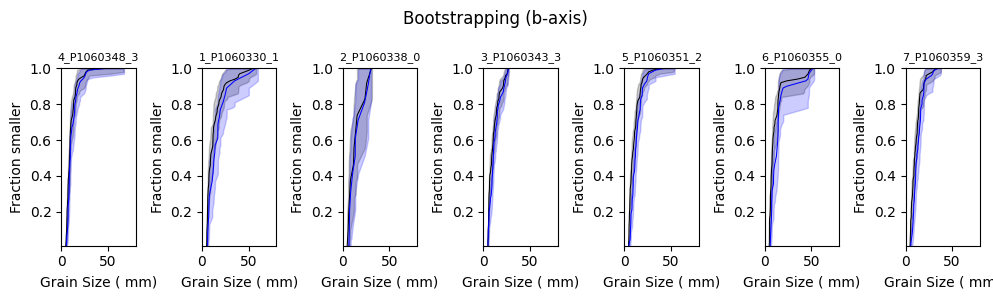

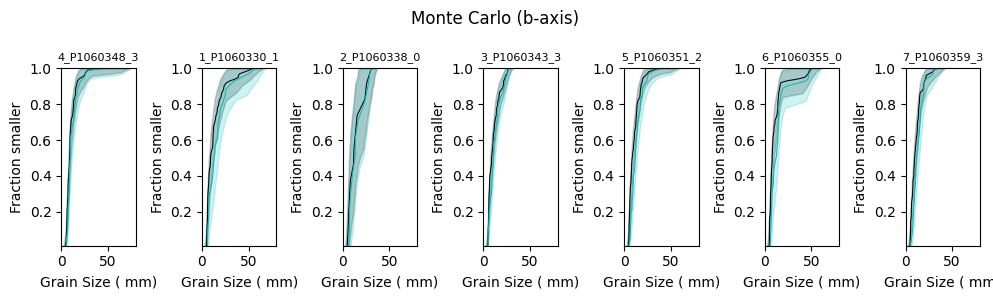

In [10]:
plt.figure(figsize=(10,3))
for i in range(len(fh_gsd_l)):
    plt.subplot(1,len(fh_gsd_l),i+1)
    #plot gt gsd for reference
    plotting.plot_gsd(gt_gsd_l[i],color='k',length_max=80,orientation='vertical',label_axes=True,units= 'mm',title=fh_id_l[i].split(f'_{model_id}_pred')[0])
    #plot gt uncertainty for reference
    plotting.plot_gsd_uncert(res_dict_gt_bs[gt_id_l[i]],color='k')
    #plot gsd
    plotting.plot_gsd(fh_gsd_l[i],color='b',length_max=80,orientation='vertical',label_axes=True,units= 'mm')
    #plot uncertainty
    plotting.plot_gsd_uncert(res_dict_bs[fh_id_l[i]],color='b')
    plt.suptitle('Bootstrapping (b-axis)')

plt.figure(figsize=(10,3))
for i in range(len(fh_gsd_l)):
    plt.subplot(1,len(fh_gsd_l),i+1)
    #plot gt gsd for reference
    plotting.plot_gsd(gt_gsd_l[i],color='k',length_max=80,orientation='vertical',label_axes=True,units= 'mm',title=fh_id_l[i].split(f'_{model_id}_pred')[0])
    #plot gt uncertainty for reference
    plotting.plot_gsd_uncert(res_dict_gt_MC[gt_id_l[i]],color='k')
    #plot gsd
    plotting.plot_gsd(fh_gsd_l[i],color='c',length_max=80,orientation='vertical',label_axes=True,units= 'mm')
    #plot uncertainty
    plotting.plot_gsd_uncert(res_dict_MC[fh_id_l[i]],color='c')
    plt.suptitle('Monte Carlo (b-axis)')

## Calculate grain size statistics for each image

In [11]:
summary_df = grainsizing.summary_statistics(fh_pred_gsds,fh_id_l,res_dict=res_dict_bs,data_id='fh_demo',save_summary=True)
summary_df

,Image/Masks,number of grains,D16,CI D16 (95%),D50,CI D50 (95%),D84,CI D84 (95%),D96,CI D96 (95%),unit,axis,method,grain approximation
0,4_P1060348_3_IG2_full_set_pred_grains_re_scaled,48,18.5,[6.2 8.1],24.9,[ 8.6 10.9],41.8,[13.7 22.2],67.6,[17.8 67.4],mm,b-axis,bootstrapping,ellipse
1,1_P1060330_1_IG2_full_set_pred_grains_re_scaled,26,18.1,[ 6.1 10.1],34.1,[ 9.3 17.9],63.5,[17.1 50.3],128.9,[22.6 60.1],mm,b-axis,bootstrapping,ellipse
2,2_P1060338_0_IG2_full_set_pred_grains_re_scaled,11,18.6,[ 6.6 12. ],34.5,[ 7.4 23.5],64.4,[13.5 30.4],74.9,[16.5 30.4],mm,b-axis,bootstrapping,ellipse
3,3_P1060343_3_IG2_full_set_pred_grains_re_scaled,65,15.2,[5.3 7.5],27.4,[ 9.6 12.6],50.2,[14.9 23.6],66.2,[22.5 27. ],mm,b-axis,bootstrapping,ellipse
4,5_P1060351_2_IG2_full_set_pred_grains_re_scaled,51,18.6,[6.7 9. ],31.3,[ 9.8 13.9],49.7,[15.9 24.4],67.6,[19.5 54.3],mm,b-axis,bootstrapping,ellipse
5,6_P1060355_0_IG2_full_set_pred_grains_re_scaled,27,18.1,[6. 9.1],31.9,[ 7.7 14.3],44.6,[14.3 47.2],121.5,[16.2 53. ],mm,b-axis,bootstrapping,ellipse
6,7_P1060359_3_IG2_full_set_pred_grains_re_scaled,44,21.0,[7.1 9.6],31.3,[10.7 15. ],49.3,[15.9 22.2],74.9,[19.7 37.9],mm,b-axis,bootstrapping,ellipse
